In [199]:
import warnings
warnings.filterwarnings("ignore")

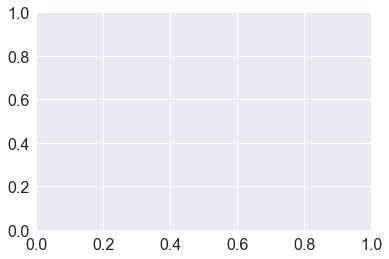

In [200]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation, linear_model
from sklearn.linear_model import Ridge
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams.update({'font.size': 16})
plt.tick_params(axis='both', which='major', labelsize=16)
fig_size = plt.rcParams["figure.figsize"]
fig_size = [22, 17]
plt.rcParams["figure.figsize"] = fig_size

from IPython.html.widgets import interact
from IPython.display import display

In [201]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [202]:
sales = pd.read_csv('sales.csv', delimiter=';', decimal=',')
media = pd.read_csv('media.csv', delimiter=';', decimal=',')


# Feature engineering

Так как в величинах общих данных (WholeMarket и Price WholeMarket) уже включен brand X, то было принято решение о выделении новой категории для описания общего объема продаж и цены конкурентов - ConcurentMarket и Price Concurents. 
Кроме того, так как у нас нету цен и объема продаж каждого конкурента отдельно, то можно заменить данные по объему каждого бренда на аггрегирующую велечину. Сделаем это как для конкурентов, так и для рынка в целом. 

In [203]:
data = pd.merge(sales, media, on = ['Year', 'Month'], how = 'left').fillna(0)
data['ConcurentMarket'] = data['WholeMarket'] - data['brand_X']
data['Price Concurents'] = (data['WholeMarket'] * data['Price WholeMarket'] - data['brand_X'] * data['Price brand_X']) / data['ConcurentMarket']
data['Price ratio'] = data['Price brand_X'] / data['Price Concurents']

data['TV.Concurents'] = data[[ c for c in data.columns if 'TV.brand' in c and 'X' not in c and 'Reg' not in c]].sum(axis = 1)
data['Reg.TV.Concurents'] = data[[ c for c in data.columns if 'Reg.TV.brand' in c and 'X' not in c]].sum(axis = 1)
data['Radio.Concurents'] = data[[ c for c in data.columns if 'Radio.brand' in c and 'X' not in c]].sum(axis = 1)
data['Press.Concurents'] = data[[ c for c in data.columns if 'Press.brand' in c and 'X' not in c]].sum(axis = 1)

data['TV.Whole'] = data['TV.Concurents'] + data['TV.brand_X']
data['Reg.TV.Whole'] = data['Reg.TV.Concurents'] + data['Reg.TV.brand_X']
data['Radio.Whole'] = data['Radio.Concurents'] + data['Radio.brand_X']
data['Press.Whole'] = data['TV.Concurents'] + data['Press.brand_X']

data['Adv_X'] = data['TV.brand_X'] + data['Radio.brand_X'] + data['Press.brand_X'] + data['Reg.TV.brand_X']
data['Adv_Concurents'] = data['TV.Concurents'] + data['Radio.Concurents'] + data['Press.Concurents'] + data['Reg.TV.Concurents']

data.head()

,Year,Month,brand_X,WholeMarket,Price brand_X,Price WholeMarket,TV.brand_X,TV.brand_1,TV.brand_2,TV.brand_3,TV.brand_4,TV.brand_5,TV.brand_6,TV.brand_7,TV.brand_8,TV.brand_9,TV.brand_10,Radio.brand_X,Radio.brand_4,Radio.brand_9,Press.brand_X,Press.brand_1,Press.brand_11,Press.brand_3,Press.brand_4,Press.brand_5,Press.brand_6,Press.brand_8,Press.brand_10,Reg.TV.brand_X,Reg.TV.brand_1,Reg.TV.brand_3,Reg.TV.brand_4,Reg.TV.brand_5,Reg.TV.brand_6,Reg.TV.brand_8,Reg.TV.brand_9,Reg.TV.brand_10,ConcurentMarket,Price Concurents,Price ratio,TV.Concurents,Reg.TV.Concurents,Radio.Concurents,Press.Concurents,TV.Whole,Reg.TV.Whole,Radio.Whole,Press.Whole,Adv_X,Adv_Concurents
0,2011,1,69280.0,4012723.0,214.430788,77.859064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3943443.0,75.459717,2.841659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011,2,63502.0,3694626.0,211.365728,78.567482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3631124.0,76.245073,2.772189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011,3,93481.0,4162842.0,213.461318,81.115540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4069361.0,78.075305,2.734044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011,4,91939.0,3843809.0,220.518252,83.583270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3751870.0,80.227700,2.748655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011,5,85633.0,3730221.0,219.280216,83.307569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3644588.0,80.112765,2.737145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


удалим объемы медиа конкурентов, кроме общих:

In [204]:
data.drop([ c for c in data.columns if 'TV.brand' in c and 'X' not in c and 'Reg' not in c], axis = 1, inplace = True)
data.drop([ c for c in data.columns if 'Reg.TV.brand' in c and 'X' not in c], axis = 1, inplace = True)
data.drop([ c for c in data.columns if 'Radio.brand' in c and 'X' not in c], axis = 1, inplace = True)
data.drop([ c for c in data.columns if 'Press.brand' in c and 'X' not in c], axis = 1, inplace = True)
data.head()

,Year,Month,brand_X,WholeMarket,Price brand_X,Price WholeMarket,TV.brand_X,Radio.brand_X,Press.brand_X,Reg.TV.brand_X,ConcurentMarket,Price Concurents,Price ratio,TV.Concurents,Reg.TV.Concurents,Radio.Concurents,Press.Concurents,TV.Whole,Reg.TV.Whole,Radio.Whole,Press.Whole,Adv_X,Adv_Concurents
0,2011,1,69280.0,4012723.0,214.430788,77.859064,0.0,0.0,0.0,0.0,3943443.0,75.459717,2.841659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011,2,63502.0,3694626.0,211.365728,78.567482,0.0,0.0,0.0,0.0,3631124.0,76.245073,2.772189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011,3,93481.0,4162842.0,213.461318,81.115540,0.0,0.0,0.0,0.0,4069361.0,78.075305,2.734044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011,4,91939.0,3843809.0,220.518252,83.583270,0.0,0.0,0.0,0.0,3751870.0,80.227700,2.748655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011,5,85633.0,3730221.0,219.280216,83.307569,0.0,0.0,0.0,0.0,3644588.0,80.112765,2.737145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Графический анализ

Построим несколько графиков:

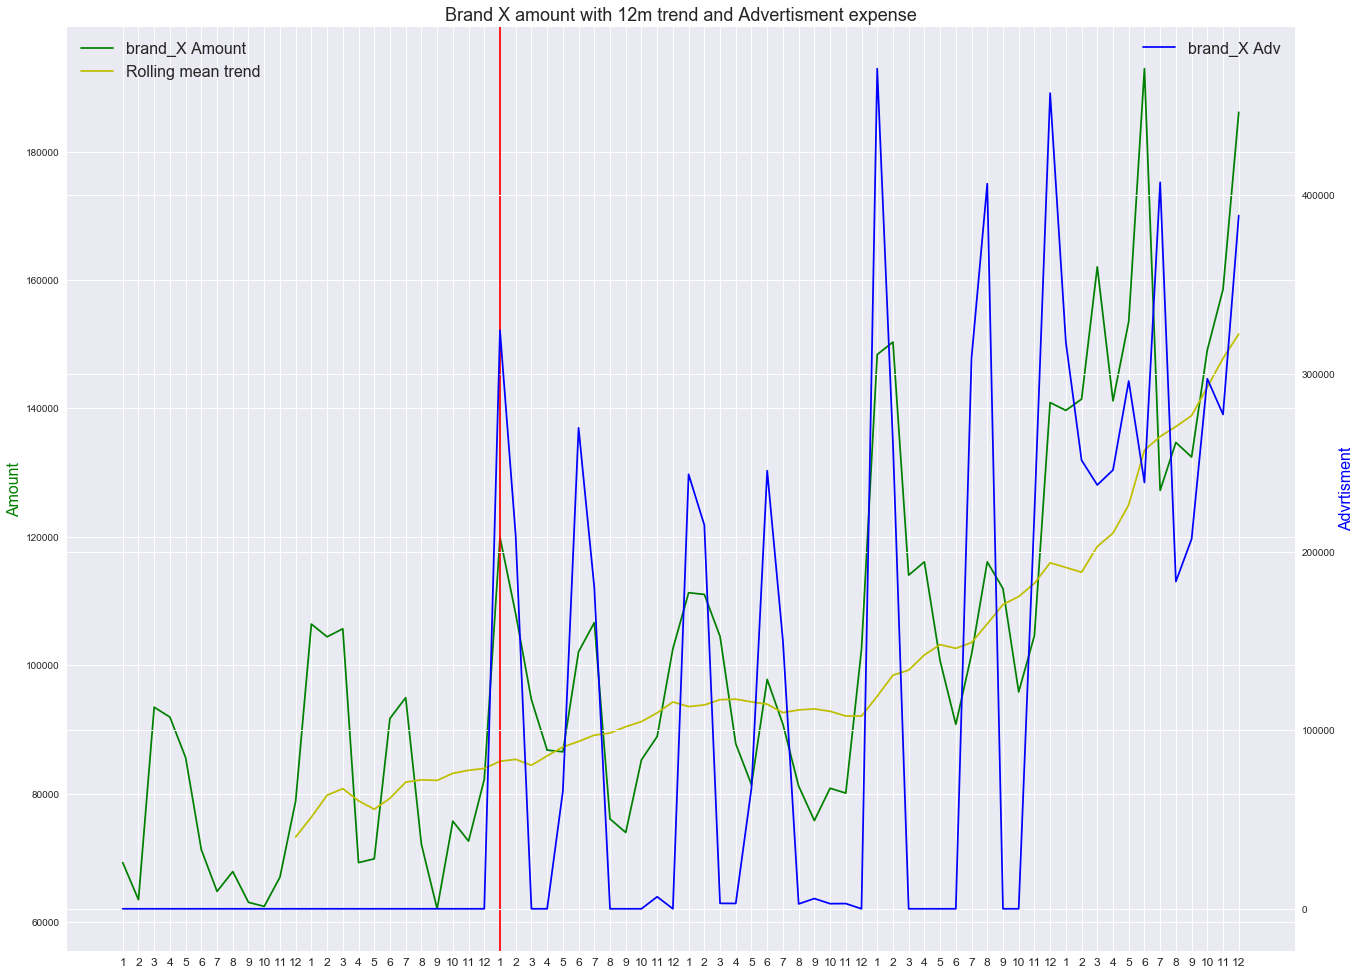

In [205]:
rolling_mean = data.brand_X.rolling(window=12).mean()
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(data.index, data.brand_X, 'g-', label="brand_X Amount")
ax1.plot(rolling_mean, "y", label="Rolling mean trend")
ax1.axvline(x=24, color = 'r')
ax2.plot(data.index, data.Adv_X, 'b-', label="brand_X Adv")

plt.xticks(data.index)
ax1.set_xticklabels((data["Month"].map(str)), fontsize = 12)
ax1.set_ylabel('Amount', color='g', fontsize = 16)
ax2.set_ylabel('Advrtisment', color='b', fontsize = 16)
ax1.legend(loc="upper left", fontsize = 16)
ax2.legend(loc="upper right", fontsize = 16)
plt.title('Brand X amount with 12m trend and Advertisment expense', fontsize = 18)
plt.show()

В основном пики по продажам приходятся на пики по рекламным расходам

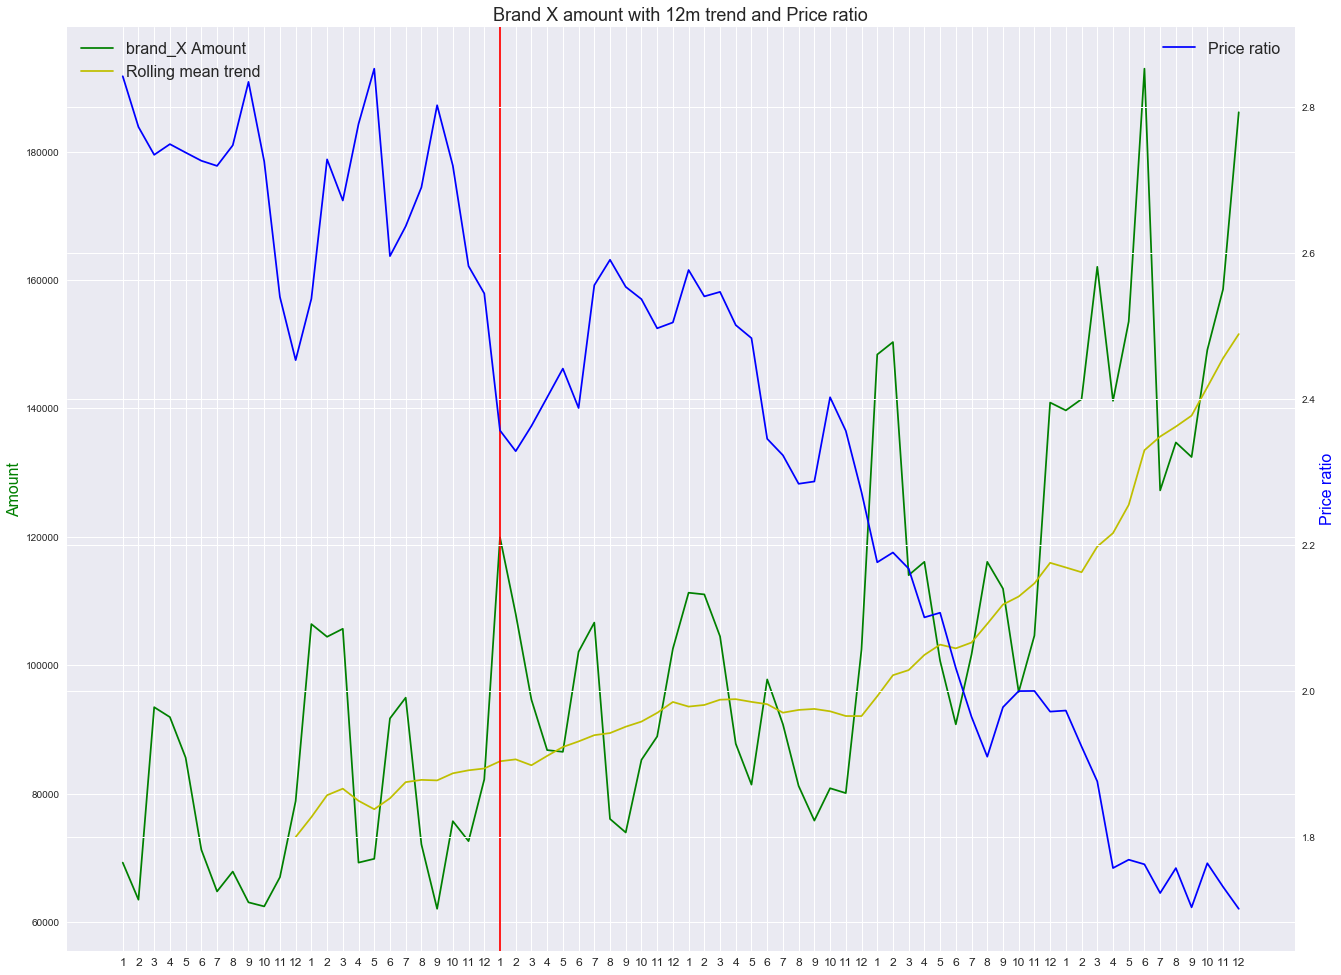

In [206]:
rolling_mean = data.brand_X.rolling(window=12).mean()
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(data.index, data.brand_X, 'g-', label="brand_X Amount")
ax1.plot(rolling_mean, "y", label="Rolling mean trend")
ax1.axvline(x=24, color = 'r')
ax2.plot(data.index, data['Price ratio'], 'b-', label="Price ratio")

plt.xticks(data.index)
ax1.set_xticklabels((data["Month"].map(str)), fontsize = 12)
ax1.set_ylabel('Amount', color='g', fontsize = 16)
ax2.set_ylabel('Price ratio', color='b', fontsize = 16)
ax1.legend(loc="upper left", fontsize = 16)
ax2.legend(loc="upper right", fontsize = 16)
plt.title('Brand X amount with 12m trend and Price ratio', fontsize = 18)
plt.show()

Отношение цены бренда Х к конкурентам очень сильно влияет на продажи: чем меньше цена бренда отличается от цен конкурентов, тем больше спрос на этот товар

Посмотрим на объем продаж и его долю по отношению по рынку по месяцам:

In [207]:
@interact(year = ['all'] + list(range(2011, 2017)))
def get_month_level(year):
    data_months = data.groupby(['Month']).sum() if(year == 'all') else data[data.Year == int(year)].groupby(['Month']).sum()
    data_months['percent'] = data_months.brand_X / data_months.WholeMarket
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(data_months.index, data_months.brand_X, 'g-', label="brand_X Amount")
    ax2.plot(data_months.index, data_months.percent, 'b-', label="brand_X Percent")

    plt.xticks(data_months.index)
    ax1.set_ylabel('Amount', color='g', fontsize = 16)
    ax2.set_ylabel('Percent', color='b', fontsize = 16)
    ax1.legend(loc="upper left", fontsize = 16)
    ax2.legend(loc="upper right", fontsize = 16)
    plt.title('Year = ' + str(year), fontsize = 16)
    plt.show()

В каждом году есть пики и спады. Обычно пики в конце и начале года, а также в середине года.

Посмотрим на распределение продаж по сезонам года. Для этого введем новое поле Season:

In [208]:
data['Season'] = data.Month.map(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Autumn')


In [209]:
@interact(year = ['all'] + list(range(2011, 2017)))
def get_month_level(year):
    data_months = data.groupby(['Season']).sum() if(year == 'all') else data[data.Year == int(year)].groupby(['Season']).sum()
    data_months['percent'] = data_months.brand_X / data_months.ConcurentMarket
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot([1, 2, 3, 4], data_months.brand_X, 'g-', label="brand_X Amount")
    ax2.plot([1, 2, 3, 4], data_months.percent, 'b-', label="brand_X Percent")
    plt.xticks([1, 2, 3, 4])
    ax1.set_xticklabels(list(data_months.index), fontsize = 16)
    ax1.set_ylabel('Amount', color='g', fontsize = 16)
    ax2.set_ylabel('Percent', color='b', fontsize = 16)
    ax1.legend(loc="upper left", fontsize = 16)
    ax2.legend(loc="upper right", fontsize = 16)
    plt.title('Year = ' + str(year), fontsize = 16)
    plt.show()

Довольно часто пики продаж приходятся на зиму. Можно включить в модель переменную Season

Графики объемов продаж и затрат на рекламу бренда Х и конкурентов:

In [210]:
@interact(i = ['Reg.TV.', 'Radio.', 'TV.', 'Press.'])
def plot_chart(i):
    for side in ['brand_X', 'Concurents']:
        amount = data['ConcurentMarket'] if(side == 'Concurents') else data['brand_X']
        fig, ax1 = plt.subplots()

        ax2 = ax1.twinx()
        ax1.plot(data.index, amount, 'g-', label= side)
        ax2.plot(data.index, data[i + side], 'r-',label=i + side)

        plt.xticks(data.index)
        ax1.set_ylabel('Amount', color='g', fontsize = 16)
        ax2.set_ylabel(i + side, color='r', fontsize = 16)
        ax1.legend(loc="upper left", fontsize = 16)
        ax2.legend(loc="upper right", fontsize = 16)
        plt.show()

Поведение графиков по видам рекламы примерно совпадает. 

Так как рекламная активность конкурентов оказывает негативное влияние на продажи бренда Х, заменим у них знак на противоположный.
Кроме того удалим все общие для брнеда Х и конкурентов данные

In [211]:
data[['Price Concurents','TV.Concurents', 'Reg.TV.Concurents', 'Press.Concurents', 'Adv_Concurents'] ]= -data[['Price Concurents','TV.Concurents', 'Reg.TV.Concurents', 'Press.Concurents', 'Adv_Concurents']]

In [212]:
cols_to_drop = [c for c in data.columns if 'Whole' in c]
data.drop(cols_to_drop, axis = 1, inplace = True)


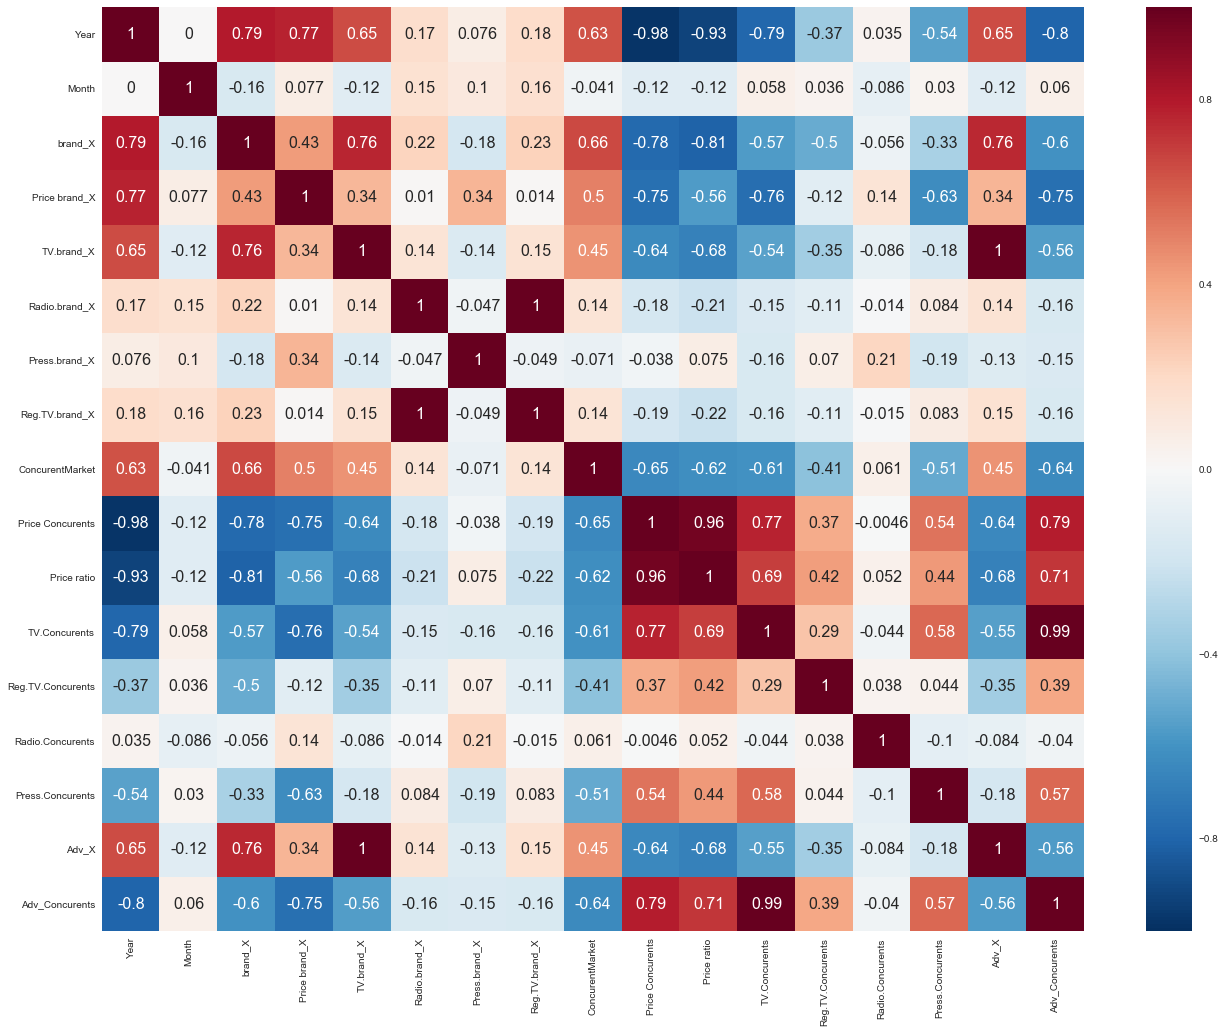

In [213]:
sns.heatmap(data.corr(), annot = True);

Общие рекламные затраты практически полностью коррелируют с затратами на TV как для бренда Х, так и дя конкурентов. Их можно исключить. Для бренда Х есть корреляция между Радио и Региональным ТВ, но это лишь потому, что данным по ним очень мало.

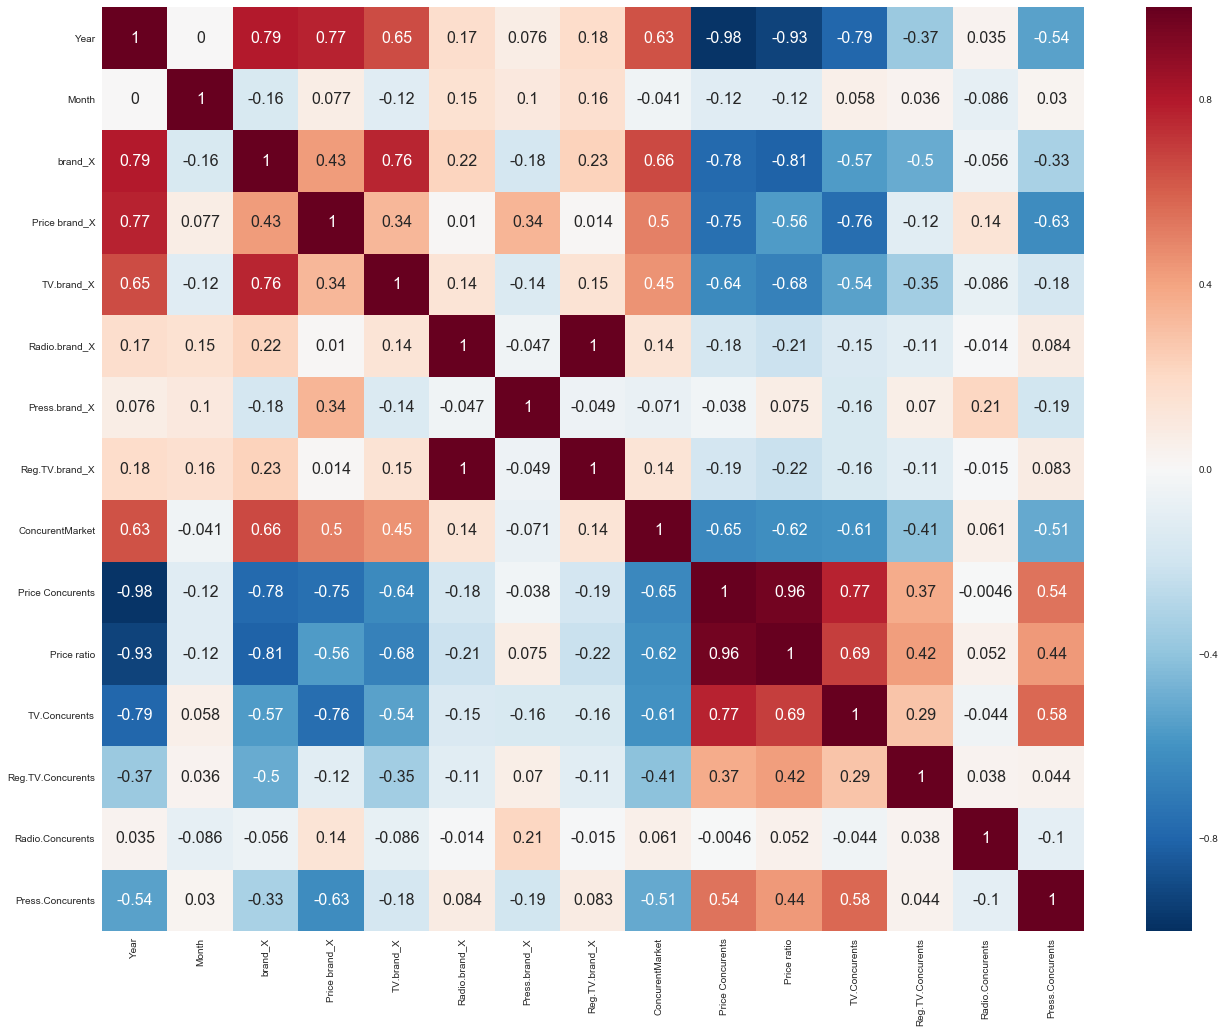

In [214]:
data.drop(['Adv_X', 'Adv_Concurents'], axis = 1, inplace = True)
sns.heatmap(data.corr(), annot = True);

Посмотрим корреляцию категориальных переменных:

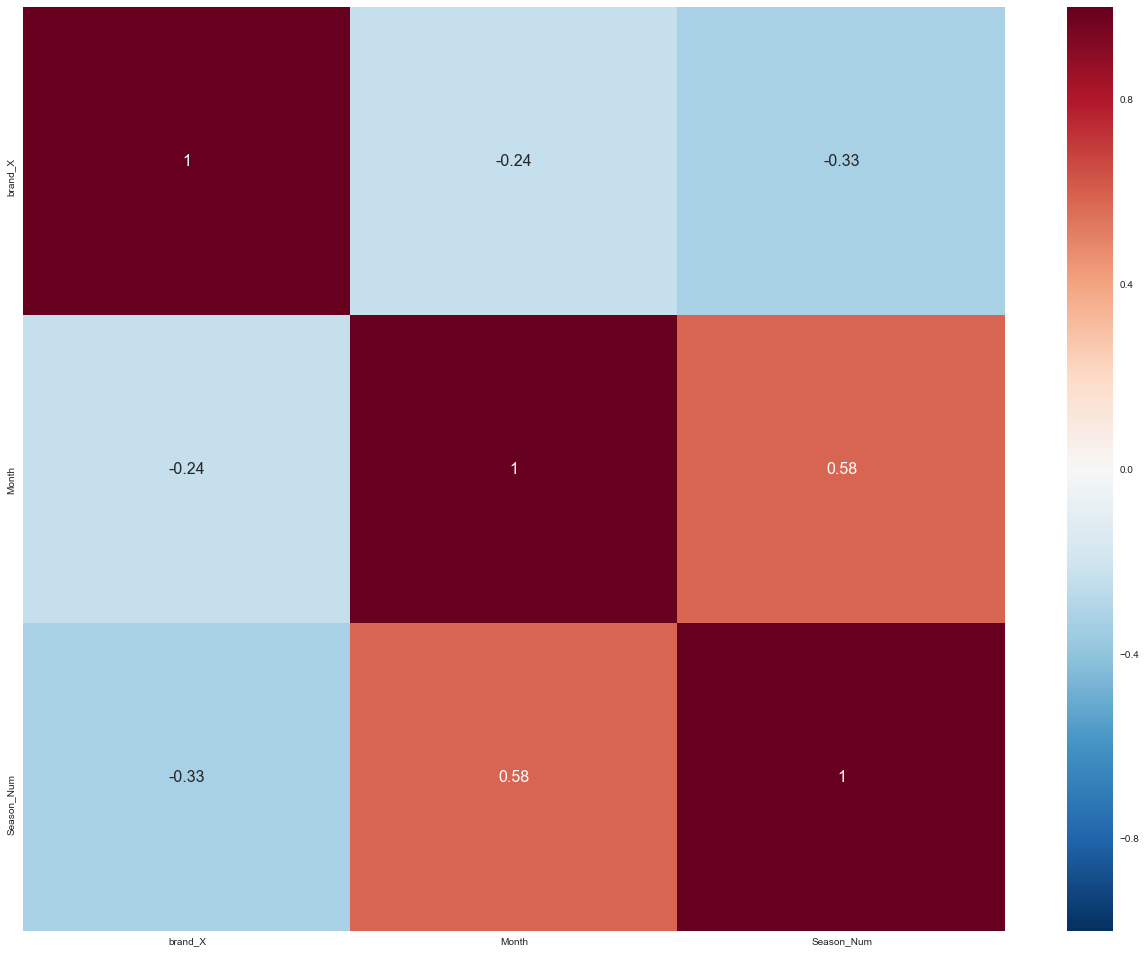

In [215]:
data['Season_Num'] = data.Season.map(lambda x: 1 if x == 'Winter' else 2 if x == 'Spring' else 3 if x == 'Summer' else 4)
sns.heatmap(data[['brand_X', 'Month', 'Season_Num']].corr(method = 'spearman'), annot = True);


In [216]:
data.drop(['Season_Num'], axis = 1, inplace = True)

Есть небольшая отрицательная корреляция

Создадим функции для преобразования датасета:

In [133]:
def get_categorial_columns(df, columns):
    for col in columns:
        df = pd.concat([df.drop([col], axis = 1), pd.get_dummies(df[col], prefix=col)], axis = 1)

    return df

def prepareData(df, cat_columns, lag, lagged_columns, test_size):
    data = pd.DataFrame(df.copy())
    data = get_categorial_columns(data, cat_columns)
    data = data.reset_index(drop=True)
    test_index = int(len(data)*(1-test_size))
    for col in lagged_columns:
        for i in range(1, lag + 1):
            data[col + '_lag' + str(i)] = data[col].shift(i)

    data.fillna(0, inplace = True)
    X_train = data.loc[:test_index].drop(["brand_X"], axis=1)
    y_train = data.loc[:test_index]["brand_X"]
    X_valid = data.loc[test_index:].drop(["brand_X"], axis=1)
    y_valid = data.loc[test_index:]["brand_X"]
    X_test_base = data.tail(12).drop(["brand_X"], axis=1)
    y_test_base = data.tail(12)["brand_X"]

    return X_train, y_train, X_valid, y_valid, X_test_base, y_test_base

def prepareDataOLS(df, cat_columns, lag, lagged_columns, test_size):
    data = pd.DataFrame(df.copy())
    data = data.reset_index(drop=True)
    test_index = int(len(data)*(1-test_size))
    for col in lagged_columns:
        for i in range(1, lag + 1):
            data[col + '_lag' + str(i)] = data[col].shift(i)

    data.fillna(0, inplace = True)
    X_train = data.loc[:test_index].drop(["brand_X"], axis=1)
    y_train = data.loc[:test_index]["brand_X"]
    X_valid = data.loc[test_index:].drop(["brand_X"], axis=1)
    y_valid = data.loc[test_index:]["brand_X"]
    X_test_base = data.tail(12).drop(["brand_X"], axis=1)
    y_test_base = data.tail(12)["brand_X"]

    return X_train, y_train, X_valid, y_valid, X_test_base, y_test_base



# Эконометрический подход построения модели

Будем использовать Линейную регрессию для построения модели продаж бренда Х.
Обучать модель будем по 64 месяцам с января 2011 по апрель 2016. Валидировать по периоду май-декабрь 2016 года.
Лаг для рекламных затрат, цен и объемам продаж взят в 4 месяца (опытным путем).

In [134]:
X, y, X_test, y_test, X_test_base, y_test_base = prepareDataOLS(data[['brand_X', 'Year', 'Price brand_X', 'Price Concurents', 'Price ratio',
     'TV.brand_X', 'Press.brand_X', 'Reg.TV.brand_X', 'TV.Concurents', 'Press.Concurents', 'Reg.TV.Concurents']], 
            ['Month'], 
            4, 
            ['brand_X', 'Price brand_X', 'Price Concurents', 'Price ratio',
             'TV.brand_X', 'Press.brand_X', 'Reg.TV.brand_X', 'TV.Concurents', 'Press.Concurents', 'Reg.TV.Concurents'],
            0.1)

# удалялись переменные, у которых была  
X.drop(['Reg.TV.brand_X_lag4', 'brand_X_lag3', 'TV.Concurents_lag3', 'Press.Concurents_lag3', 
       'Price ratio_lag3', 'Press.Concurents_lag4', 'brand_X_lag4', 'Price ratio_lag4', 'TV.brand_X_lag4', 
        'Reg.TV.brand_X_lag3', 'brand_X_lag2', 'TV.Concurents_lag4', 'Press.brand_X_lag4', 'Price brand_X_lag4',
       'TV.Concurents', 'Press.Concurents', 'Price Concurents_lag4', 'Reg.TV.Concurents', 'Reg.TV.Concurents_lag4',
       'Reg.TV.brand_X', 'Press.brand_X', 'TV.brand_X_lag3', 'Price brand_X_lag1', 'Press.brand_X_lag1',
       'Reg.TV.Concurents_lag1', 'TV.Concurents_lag1', 'Press.brand_X_lag3', 'Price ratio_lag1',
       'Reg.TV.Concurents_lag2', 'TV.brand_X_lag1', 'Reg.TV.Concurents_lag3', 'Reg.TV.brand_X_lag1','Price brand_X_lag3'], axis = 1, inplace = True)
X_test.drop(['Reg.TV.brand_X_lag4', 'brand_X_lag3', 'TV.Concurents_lag3', 'Press.Concurents_lag3', 
       'Price ratio_lag3', 'Press.Concurents_lag4', 'brand_X_lag4', 'Price ratio_lag4', 'TV.brand_X_lag4', 
        'Reg.TV.brand_X_lag3', 'brand_X_lag2', 'TV.Concurents_lag4', 'Press.brand_X_lag4', 'Price brand_X_lag4',
       'TV.Concurents', 'Press.Concurents', 'Price Concurents_lag4', 'Reg.TV.Concurents', 'Reg.TV.Concurents_lag4',
       'Reg.TV.brand_X', 'Press.brand_X', 'TV.brand_X_lag3', 'Price brand_X_lag1', 'Press.brand_X_lag1',
       'Reg.TV.Concurents_lag1', 'TV.Concurents_lag1', 'Press.brand_X_lag3', 'Price ratio_lag1',
       'Reg.TV.Concurents_lag2', 'TV.brand_X_lag1', 'Reg.TV.Concurents_lag3', 'Reg.TV.brand_X_lag1','Price brand_X_lag3'], axis = 1, inplace = True)



                            OLS Regression Results                            
Dep. Variable:                brand_X   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     26.47
Date:                Mon, 08 Jan 2018   Prob (F-statistic):           1.94e-18
Time:                        08:14:21   Log-Likelihood:                -672.69
No. Observations:                  65   AIC:                             1381.
Df Residuals:                      47   BIC:                             1421.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   1.32e

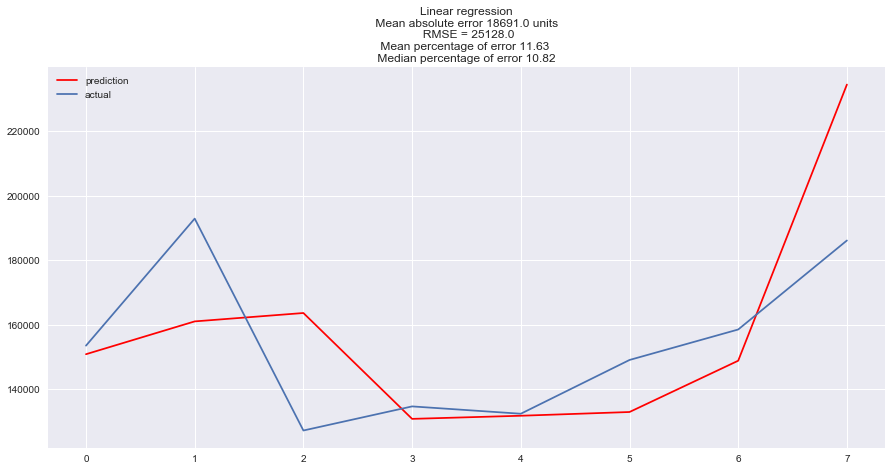

In [135]:
# Для того, чтобы убрать мультиколлинеарность, проводилася нормализация данных

min_max_scaler = preprocessing.MinMaxScaler()

X2 = sm.add_constant(min_max_scaler.fit_transform(X))
X3 = sm.add_constant(min_max_scaler.transform(X_test), has_constant='add')
est = sm.OLS(y, X2)
est = est.fit()
print()
print(est.summary(xname=['const'] + list(X.columns)))
prediction = est.predict(X3)
   
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
error_percentage = (abs(prediction - y_test.values) / y_test.values)
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} units \n  RMSE = {} \n Mean percentage of error {}  \n Median percentage of error {} ".format(
    round(mean_absolute_error(y_test, prediction)),
    round(np.sqrt(mean_squared_error(y_test, prediction))), 
    round(sum(error_percentage) / len(error_percentage) * 100, 2),
    round(sorted(error_percentage)[int(len(error_percentage) / 2)] * 100, 2) ))
plt.grid(True);
plt.show()

Получилась модель, которая дает около 10% погрешность на тестовой выборке. Это около 19 тыс единиц товара.
На тренировочной выборке она ожидаемо показывает результат лучше: погрешность около 6,5%.

                            OLS Regression Results                            
Dep. Variable:                brand_X   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     26.47
Date:                Mon, 08 Jan 2018   Prob (F-statistic):           1.94e-18
Time:                        08:14:21   Log-Likelihood:                -672.69
No. Observations:                  65   AIC:                             1381.
Df Residuals:                      47   BIC:                             1421.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   1.32e+

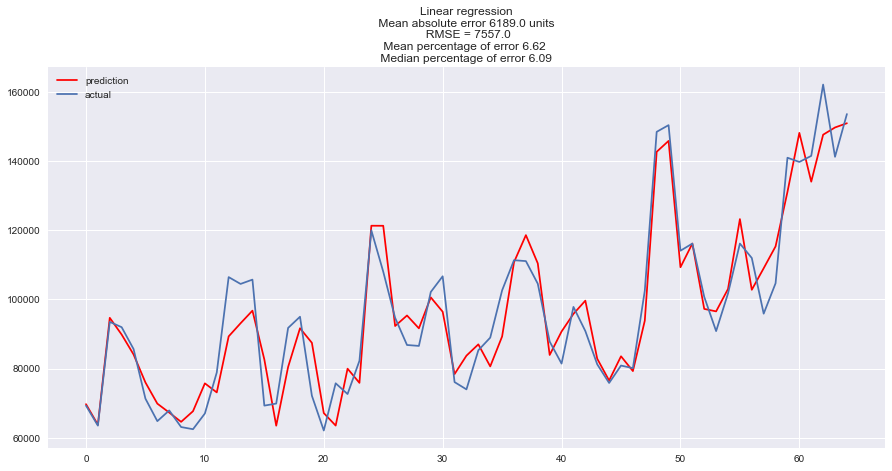

In [136]:
min_max_scaler = preprocessing.MinMaxScaler()

X2 = sm.add_constant(min_max_scaler.fit_transform(X))
X3 = sm.add_constant(min_max_scaler.transform(X), has_constant='add')
est = sm.OLS(y, X2)
est = est.fit()

print(est.summary(xname=['const'] + list(X.columns)))
prediction = est.predict(X3)
   
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y.values, label="actual")
error_percentage = (abs(prediction - y.values) / y.values)
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} units \n  RMSE = {} \n Mean percentage of error {}  \n Median percentage of error {} ".format(
    round(mean_absolute_error(y, prediction)),
    round(np.sqrt(mean_squared_error(y, prediction))), 
    round(sum(error_percentage) / len(error_percentage) * 100, 2),
    round(sorted(error_percentage)[int(len(error_percentage) / 2)] * 100, 2) ))
plt.grid(True);
plt.show()

# Модель машинного обучения

Для построеня модели был использован алгоритм XGBRegressor на переменных 'brand_X', 'Year', 'Month', 'Season', 'Price brand_X', 'Price Concurents', 'Price ratio', 'TV.brand_X', 'Press.brand_X', 'Reg.TV.brand_X', 'TV.Concurents', 'Press.Concurents', 'Reg.TV.Concurents', где 'brand_X' - искомая велечина, 'Month', 'Season' - категориальные переменные.
Лаг для рекламных затрат, цен и объемам продаж взят в 6 месяцев.

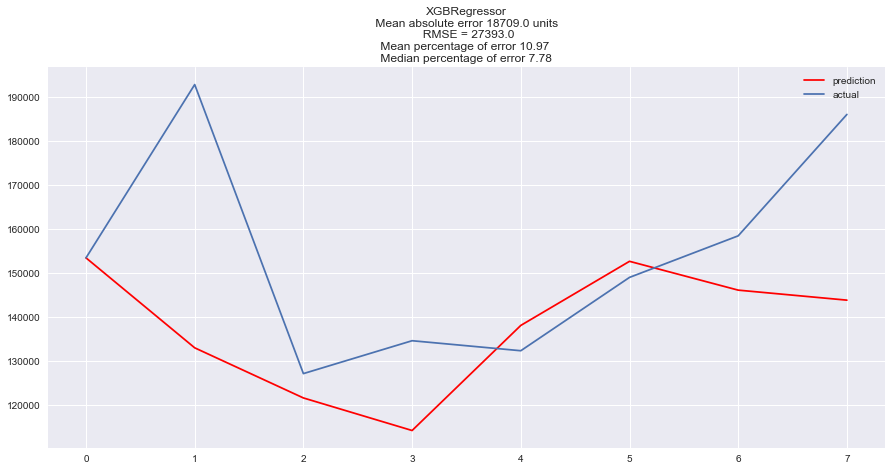

In [185]:
from xgboost import XGBRegressor
X, y, X_valid, y_valid, X_test, y_test = prepareData(data[['brand_X', 'Year', 'Month', 'Season', 'Price brand_X', 
                                                           'Price Concurents', 'Price ratio','Radio.brand_X', 'Radio.Concurents',
     'TV.brand_X', 'Press.brand_X', 'Reg.TV.brand_X', 'TV.Concurents', 'Press.Concurents', 'Reg.TV.Concurents']],
             ['Month', 'Season'], 
            6, 
            ['brand_X', 'Price brand_X', 'Price Concurents', 'Price ratio','Radio.brand_X', 'Radio.Concurents', 
             'TV.brand_X', 'Press.brand_X', 'Reg.TV.brand_X', 'TV.Concurents', 'Press.Concurents', 'Reg.TV.Concurents'],
            0.1)

est = XGBRegressor(n_estimators=1000, max_depth = 7, n_jobs=-1, random_state=42).fit(X, y)
# рассчитаем важность фич
features = pd.DataFrame(est.feature_importances_, index=X.columns, columns=['Importance']).sort_values(['Importance'], ascending=False)
prediction = est.predict(X_valid)
   
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_valid.values, label="actual")
error_percentage = (abs(prediction - y_valid.values) / y_valid.values)
plt.legend(loc="best")
plt.title("XGBRegressor\n Mean absolute error {} units \n  RMSE = {} \n Mean percentage of error {}  \n Median percentage of error {} ".format(
    round(mean_absolute_error(y_valid, prediction)),
    round(np.sqrt(mean_squared_error(y_valid, prediction))), 
    round(sum(error_percentage) / len(error_percentage) * 100, 2),
    round(sorted(error_percentage)[int(len(error_percentage) / 2)] * 100, 2) ))
plt.grid(True);
plt.show()


Делаем настройку параметров. Будем брать поочередно все больше фич в порядке возрастания их важности и, изменяя параметры регрессора, считать ошибку (MAE и RMSE).

In [99]:
grid_df = pd.DataFrame()

for i in range(5, len(features)):
    for lr in [0.1, 0.05, 0.2, 0.02]:
        for md in list(range(3, 10)):
            for s in [1, 0.75, 0.5]:
                reg = XGBRegressor(n_jobs=-1, verbose=False, random_state=42, n_estimators=1000, 
                                   learning_rate = lr, max_depth = md, subsample = s)
                reg.fit(X[list(features[:i].index)], y)
                prediction = reg.predict(X_valid[list(features[:i].index)])
                row = pd.Series([i, lr, md, s, round(mean_absolute_error(y_valid, prediction)), round(np.sqrt(mean_squared_error(y_valid, prediction))) ])
                grid_df = grid_df.append(row, ignore_index=True)  
                
grid_df.columns = ['feature_num', 'learning_rate', 'max_depth', 'subsample', 'MAE', 'RMSE']
grid_df.sort_values(['MAE']).head(5).append(grid_df.sort_values(['RMSE']).head(5)).drop_duplicates()

,feature_num,learning_rate,max_depth,subsample,MAE,RMSE
4838,62.0,0.2,5.0,0.5,12578.0,23220.0
3114,42.0,0.1,5.0,1.0,12873.0,18992.0
4922,63.0,0.2,5.0,0.5,12942.0,23145.0
2994,40.0,0.2,7.0,1.0,12988.0,18656.0
2907,39.0,0.2,6.0,1.0,13041.0,18608.0
2997,40.0,0.2,8.0,1.0,13176.0,18722.0
2823,38.0,0.2,6.0,1.0,13446.0,18737.0
2739,37.0,0.2,6.0,1.0,13446.0,18737.0


Возьмем модель с как можно меньшим MAE  и RMSE.

пересчитаем модель с новыми параметрами:

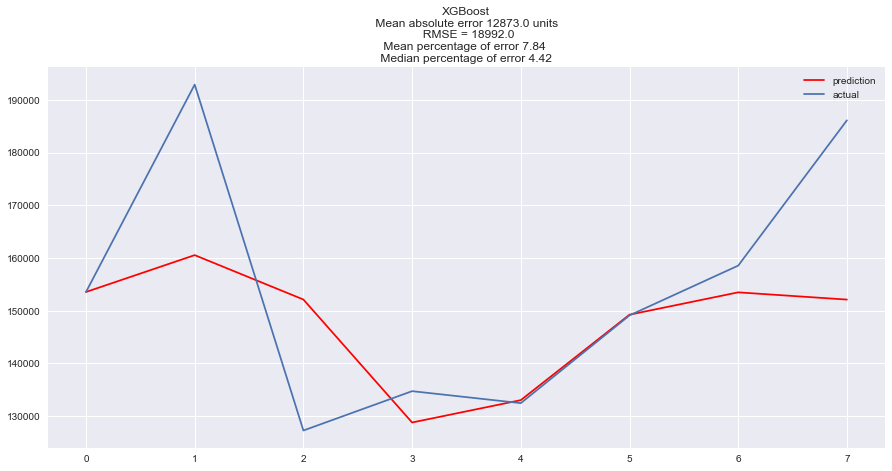

In [186]:
est = XGBRegressor(n_estimators=1000, max_depth = 5, n_jobs=-1, random_state=42, subsample = 1, learning_rate = 0.1)
est.fit(X[list(features[:42].index)], y)
# пересчитаем важность новых фич
features_new = pd.DataFrame(est.feature_importances_, index=X[list(features[:42].index)].columns, columns=['Importance']).sort_values(['Importance'], ascending=False)
prediction = est.predict(X_valid[list(features[:42].index)])
   
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_valid.values, label="actual")
error_percentage = (abs(prediction - y_valid.values) / y_valid.values)
plt.legend(loc="best")
plt.title("XGBoost\n Mean absolute error {} units \n  RMSE = {} \n Mean percentage of error {}  \n Median percentage of error {} ".format(
    round(mean_absolute_error(y_valid, prediction)),
    round(np.sqrt(mean_squared_error(y_valid, prediction))), 
    round(sum(error_percentage) / len(error_percentage) * 100, 2),
    round(sorted(error_percentage)[int(len(error_percentage) / 2)] * 100, 2) ))
plt.grid(True);
plt.show()

Получили среднюю ошибку на отложенной выборке примерно в 7% или 12500 единиц.


# Вклад медиа в модель

Для нахождения вклада каждого типа медиа в продажи возмем все использованные для построения модели фичи и уберем оттуда все, не связанное с медиа:

In [140]:
media_features = features_new[features_new.index.isin(['Press.Concurents', 'Press.Concurents_lag1', 'Press.Concurents_lag2', 'Press.Concurents_lag3',
 'Press.Concurents_lag4', 'Press.Concurents_lag5', 'Press.Concurents_lag6', 'Press.brand_X', 'Press.brand_X_lag1',
 'Press.brand_X_lag2', 'Press.brand_X_lag3', 'Press.brand_X_lag4', 'Press.brand_X_lag5', 'Press.brand_X_lag6',
 'Reg.TV.Concurents', 'Reg.TV.Concurents_lag1', 'Reg.TV.Concurents_lag2', 'Reg.TV.Concurents_lag3', 'Reg.TV.Concurents_lag4',
 'Reg.TV.Concurents_lag5', 'Reg.TV.Concurents_lag6', 'Reg.TV.brand_X', 'Reg.TV.brand_X_lag1', 'Reg.TV.brand_X_lag2', 'Reg.TV.brand_X_lag3',
 'Reg.TV.brand_X_lag4', 'Reg.TV.brand_X_lag5', 'Reg.TV.brand_X_lag6', 'Radio.Concurents', 'Radio.Concurents_lag1', 'Radio.Concurents_lag2',
 'Radio.Concurents_lag3', 'Radio.Concurents_lag4', 'Radio.Concurents_lag5', 'Radio.Concurents_lag6', 'Radio.brand_X',
 'Radio.brand_X_lag1', 'Radio.brand_X_lag2', 'Radio.brand_X_lag3', 'Radio.brand_X_lag4', 'Radio.brand_X_lag5', 'Radio.brand_X_lag6',
 'TV.Concurents', 'TV.Concurents_lag1', 'TV.Concurents_lag2', 'TV.Concurents_lag3', 'TV.Concurents_lag4', 'TV.Concurents_lag5',
 'TV.Concurents_lag6', 'TV.brand_X', 'TV.brand_X_lag1', 'TV.brand_X_lag2', 'TV.brand_X_lag3', 'TV.brand_X_lag4', 'TV.brand_X_lag5',
 'TV.brand_X_lag6'])]
media_features

,Importance
TV.Concurents,0.088916
TV.Concurents_lag6,0.012450
TV.Concurents_lag3,0.008043
Press.brand_X_lag1,0.007933
TV.brand_X,0.007823
TV.brand_X_lag1,0.005178
TV.Concurents_lag5,0.004738
Reg.TV.Concurents_lag1,0.003746
TV.brand_X_lag2,0.003305
TV.Concurents_lag2,0.002534


В модель не попали ни радио, ни региональное телевидение. Однако реклама на региональном телевидении конкурентов в модель попала. Так как наблюдаемых данных по рекламе на региональном телевидении бренда Х очень мало (3 наблюдения), то можно использовать важность показателя конкурентов. 

С учетом этого и добавления лагов получим следующие коэффициенты:

In [259]:
media_df = pd.DataFrame()
media_df = media_df.append(pd.Series(['TV', 0.007823 + 0.005178 + 0.003305]), ignore_index=True)  
media_df = media_df.append(pd.Series(['RegTV', 0.003746 + 0.002424 + 0.002093]), ignore_index=True)  
media_df = media_df.append(pd.Series(['Press', 0.007933 + 0.001322]), ignore_index=True)  
media_df

,0,1
0,TV,0.016306
1,RegTV,0.008263
2,Press,0.009255


Наблюдений по радио практически не было. поэтому для дальнейшей работы нам необходимо обязательно включить и этот тип. Для этого возьмем суммарную важность радио для всех брендов при построении модели по всем признакам и добавим ее в наш медиа микс:

In [142]:
radio_importance = features[(features.index.isin(['Radio.Concurents', 'Radio.Concurents_lag1', 'Radio.Concurents_lag2',
 'Radio.Concurents_lag3', 'Radio.Concurents_lag4', 'Radio.Concurents_lag5', 'Radio.Concurents_lag6', 'Radio.brand_X',
 'Radio.brand_X_lag1', 'Radio.brand_X_lag2', 'Radio.brand_X_lag3', 'Radio.brand_X_lag4', 'Radio.brand_X_lag5', 'Radio.brand_X_lag6',
 ])) & (features.Importance > 0)]
radio_importance

,Importance
Radio.Concurents_lag1,0.000482
Radio.Concurents,0.000088
Radio.Concurents_lag5,0.000088


Преобразуем коэффициенты в проценты:

In [260]:
media_df = media_df.append(pd.Series(['Radio', 0.000482 + 0.000088 + 0.000088]), ignore_index=True)  
media_df.columns = ['media', 'score']
media_df['perc']= media_df['score']/media_df['score'].sum()
media_df

,media,score,perc
0,TV,0.016306,0.472884
1,RegTV,0.008263,0.239632
2,Press,0.009255,0.268401
3,Radio,0.000658,0.019082


Расчитаем важность типа медиа относительно его цены:

In [261]:
media_df['importance']= [0.47/160, 0.24/100, 0.27/600, 0.02/75]
media_df

,media,score,perc,importance
0,TV,0.016306,0.472884,0.002938
1,RegTV,0.008263,0.239632,0.002400
2,Press,0.009255,0.268401,0.000450
3,Radio,0.000658,0.019082,0.000267


Распределим ресуры на рекламу относительно полученной важности типов:

In [262]:
media_df['importance_perc']= media_df['importance']/media_df['importance'].sum()
media_df

,media,score,perc,importance,importance_perc
0,TV,0.016306,0.472884,0.002938,0.485203
1,RegTV,0.008263,0.239632,0.002400,0.396421
2,Press,0.009255,0.268401,0.000450,0.074329
3,Radio,0.000658,0.019082,0.000267,0.044047


Найдем число контактов по каждому типу медиа

In [263]:
def get_media_contacts(tv, reg, press, radio):
    overall_contacts = 100000000 / (tv*160 + reg*100 + press*600 + radio*75)
    return round(tv*overall_contacts, 2), round(reg*overall_contacts, 2), round(press*overall_contacts, 2), round(radio*overall_contacts, 2)

In [264]:
tv, reg, press, radio = get_media_contacts(0.49, 0.4, 0.07, 0.04)

In [265]:
print(tv, radio, reg, press)

299877.6 24479.8 244798.04 42839.66


# Прогноз на 2017 год

Так как активность конкурентов будет такая же как в 2016 году, цена в категории и цена бренда меняться не будут, то цены оставляем на декабрь 2016, а медиа активность конкурентов делаем такую же, как в 2016 году каждого месяца.

In [266]:
def prepareData3(df, test_size):
    data = pd.DataFrame(df.copy())
    test_index = len(data) - 12
    valid_index = int(test_index*(1-test_size))

    data.fillna(0, inplace = True)
    X_train = data.loc[:valid_index-1].drop(["brand_X"], axis=1)
    y_train = data.loc[:valid_index-1]["brand_X"]
    X_valid = data.loc[valid_index:test_index-1].drop(["brand_X"], axis=1)
    y_valid = data.loc[valid_index:test_index-1]["brand_X"]
    X_test_base = data.loc[test_index:].drop(["brand_X"], axis=1)
    y_test_base = data.loc[test_index:]["brand_X"]

    return X_train, y_train, X_valid, y_valid, X_test_base, y_test_base

def prepareData2(df, cat_columns, lag, lagged_columns, test_size, tv, radio, reg, press):
    data = pd.DataFrame(df.copy())
    valid_index = int(len(data)*(1-test_size))
    
    test_df = data.copy().tail(12)
    test_df.Year = 2017
    test_df['Price brand_X'] = test_df.tail(1)['Price brand_X'].values[0]
    test_df['Price Concurents'] = test_df.tail(1)['Price Concurents'].values[0]
    test_df['Price ratio'] = test_df.tail(1)['Price ratio'].values[0]
    test_df['brand_X'] = 0
    test_df['TV.brand_X'] = tv
    test_df['Radio.brand_X'] = radio
    test_df['Reg.TV.brand_X'] = reg
    test_df['Press.brand_X'] = press
    data = data.append(test_df).reset_index(drop = True)
    
    data = get_categorial_columns(data, cat_columns)
    data = data.reset_index(drop=True)
    test_index = len(data) - 12
    for col in lagged_columns:
        for i in range(1, lag + 1):
            data[col + '_lag' + str(i)] = data[col].shift(i)

    data.fillna(0, inplace = True)
    X_train = data.loc[:valid_index-1].drop(["brand_X"], axis=1)
    y_train = data.loc[:valid_index-1]["brand_X"]
    X_valid = data.loc[valid_index:test_index-1].drop(["brand_X"], axis=1)
    y_valid = data.loc[valid_index:test_index-1]["brand_X"]
    X_test_base = data.loc[test_index:].drop(["brand_X"], axis=1)
    y_test_base = data.loc[test_index:]["brand_X"]

    return X_train, y_train, X_valid, y_valid, X_test_base, y_test_base

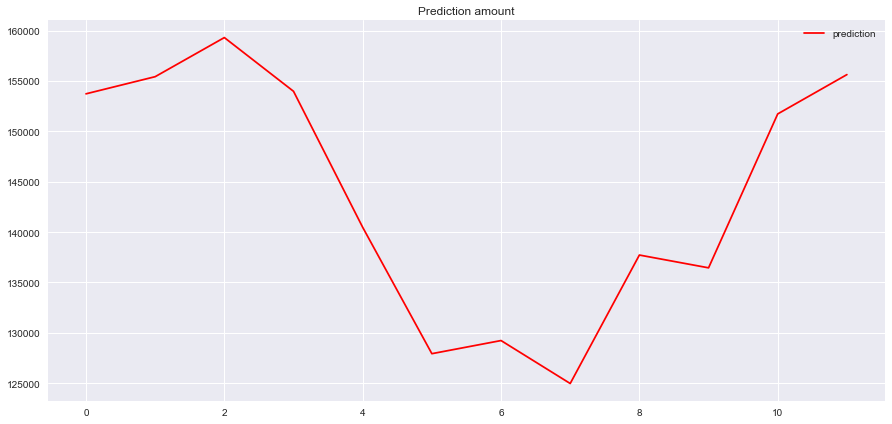

In [267]:
    lagged_columns =   ['brand_X', 'Price brand_X', 'Price Concurents', 'Price ratio','Radio.brand_X', 'Radio.Concurents', 
             'TV.brand_X', 'Press.brand_X', 'Reg.TV.brand_X', 'TV.Concurents', 'Press.Concurents', 'Reg.TV.Concurents']
    cat_columns =  ['Month', 'Season']
    df_tmp = data.copy()
    test_df = data.copy().tail(12)
    test_df.Year = 2017
    test_df['Price brand_X'] = test_df.tail(1)['Price brand_X'].values[0]
    test_df['Price Concurents'] = test_df.tail(1)['Price Concurents'].values[0]
    test_df['Price ratio'] = test_df.tail(1)['Price ratio'].values[0]
    test_df['brand_X'] = 0
    test_df['TV.brand_X'] = tv
    test_df['Radio.brand_X'] = radio
    test_df['Reg.TV.brand_X'] = reg
    test_df['Press.brand_X'] = press
    df_tmp = df_tmp.append(test_df).reset_index(drop = True)
    df_tmp = get_categorial_columns(df_tmp, cat_columns)
    data = data.reset_index(drop=True)
    test_index = len(data) - 12
    for col in lagged_columns:
        for i in range(1, 7):
            df_tmp[col + '_lag' + str(i)] = df_tmp[col].shift(i)

    df_tmp.fillna(0, inplace = True)
    X, y, X_valid, y_valid, X_test, y_test = prepareData3(df_tmp, 0.1)
    est = XGBRegressor(n_estimators=1000, max_depth = 7, n_jobs=-1, random_state=42, subsample = 1, learning_rate = 0.2)
    est.fit(X, y)
    for i in list(range(1, 13)):
        prediction = est.predict(X_test.tail(i))
        indexes = list(range(72, 72+i))
        df_tmp.set_value(indexes, 'brand_X', prediction, takeable=False)
        for i in range(1, 7):
            df_tmp['brand_X_lag' + str(i)] = df_tmp['brand_X'].shift(i)

    X, y, X_valid, y_valid, X_test, y_test = prepareData3(df_tmp, 0.1)
    est = XGBRegressor(n_estimators=1000, max_depth = 7, n_jobs=-1, random_state=42, subsample = 1, learning_rate = 0.2)
    est.fit(X, y)
    prediction = est.predict(X_test)
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "r", label="prediction")
    plt.legend(loc="best")
    plt.title('Prediction amount')
    plt.grid(True);
    plt.show()    

# Возможные улучшения

Так как в модели вес региональной рекламы бренда Х довольно мал (мы заменили его долю на долю конкурентов), то в предсказании объем инвестиций в региональную рекламу практически не учитывается.
Можно поробовать ввести новую переменную - разность контактов на региональную рекламу бренда Х и конкурентов и ей заменить отдельные статьи данному типу рекламы.
Кроме того можно обучить модель на всей выборке, а не на ее части. Модель должна обучиться немного лучше.


Также предсказания на 2017 год можно делать постепенно, месяц за месяцем, добавляя полученное значение brand_X для расчета лаговых переменных.

In [270]:
data['RegDiff'] = data['Reg.TV.brand_X'] - data['Reg.TV.Concurents'].abs()


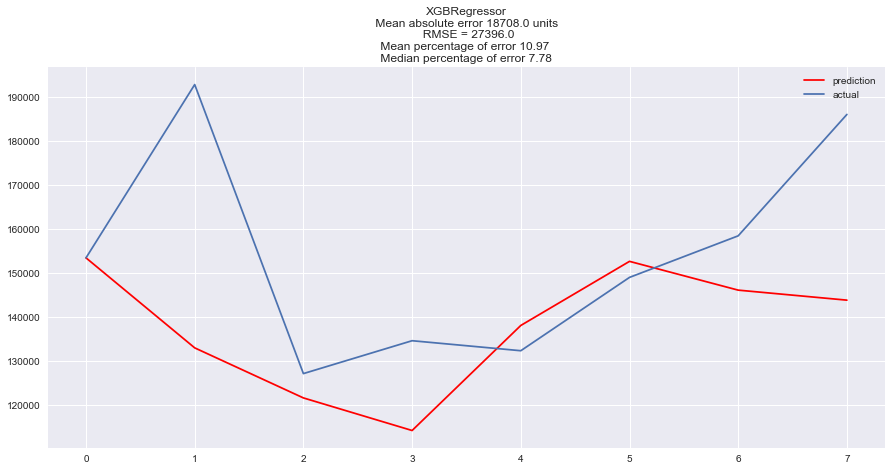

In [273]:
from xgboost import XGBRegressor
X, y, X_valid, y_valid, X_test, y_test = prepareData(data[['brand_X', 'Year', 'Month', 'Season', 'Price brand_X', 
                                                           'Price Concurents', 'Price ratio','Radio.brand_X', 'Radio.Concurents',
     'TV.brand_X', 'Press.brand_X', 'TV.Concurents', 'Press.Concurents', 'RegDiff']],
             ['Month', 'Season'], 
            6, 
            ['brand_X', 'Price brand_X', 'Price Concurents', 'Price ratio','Radio.brand_X', 'Radio.Concurents', 
             'TV.brand_X', 'Press.brand_X', 'TV.Concurents', 'Press.Concurents', 'RegDiff'],
            0.1)

est = XGBRegressor(n_estimators=1000, max_depth = 7, n_jobs=-1, random_state=42).fit(X, y)
# рассчитаем важность фич
features = pd.DataFrame(est.feature_importances_, index=X.columns, columns=['Importance']).sort_values(['Importance'], ascending=False)
prediction = est.predict(X_valid)
   
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_valid.values, label="actual")
error_percentage = (abs(prediction - y_valid.values) / y_valid.values)
plt.legend(loc="best")
plt.title("XGBRegressor\n Mean absolute error {} units \n  RMSE = {} \n Mean percentage of error {}  \n Median percentage of error {} ".format(
    round(mean_absolute_error(y_valid, prediction)),
    round(np.sqrt(mean_squared_error(y_valid, prediction))), 
    round(sum(error_percentage) / len(error_percentage) * 100, 2),
    round(sorted(error_percentage)[int(len(error_percentage) / 2)] * 100, 2) ))
plt.grid(True);
plt.show()

In [275]:
grid_df = pd.DataFrame()

for i in range(9, len(features)):
    for lr in [0.1, 0.05, 0.2, 0.02]:
        for md in list(range(3, 10)):
            for s in [1, 0.75, 0.5]:
                reg = XGBRegressor(n_jobs=-1, verbose=False, random_state=42, n_estimators=1000, 
                                   learning_rate = lr, max_depth = md, subsample = s)
                reg.fit(X[list(features[:i].index)], y)
                prediction = reg.predict(X_valid[list(features[:i].index)])
                row = pd.Series([i, lr, md, s, round(mean_absolute_error(y_valid, prediction)), round(np.sqrt(mean_squared_error(y_valid, prediction))) ])
                grid_df = grid_df.append(row, ignore_index=True)  
                
grid_df.columns = ['feature_num', 'learning_rate', 'max_depth', 'subsample', 'MAE', 'RMSE']
grid_df.sort_values(['MAE']).head(5).append(grid_df.sort_values(['RMSE']).head(5)).drop_duplicates()

,feature_num,learning_rate,max_depth,subsample,MAE,RMSE
5768,77.0,0.20,7.0,0.5,13456.0,22249.0
5684,76.0,0.20,7.0,0.5,13456.0,22249.0
5642,76.0,0.10,7.0,0.5,13521.0,22539.0
5726,77.0,0.10,7.0,0.5,13521.0,22539.0
5771,77.0,0.20,8.0,0.5,13592.0,21597.0
3912,55.0,0.20,5.0,1.0,14358.0,19541.0
3828,54.0,0.20,5.0,1.0,14539.0,19618.0
2463,38.0,0.05,5.0,1.0,14961.0,20350.0
2379,37.0,0.05,5.0,1.0,14954.0,20352.0
4502,62.0,0.20,5.0,0.5,15760.0,20354.0


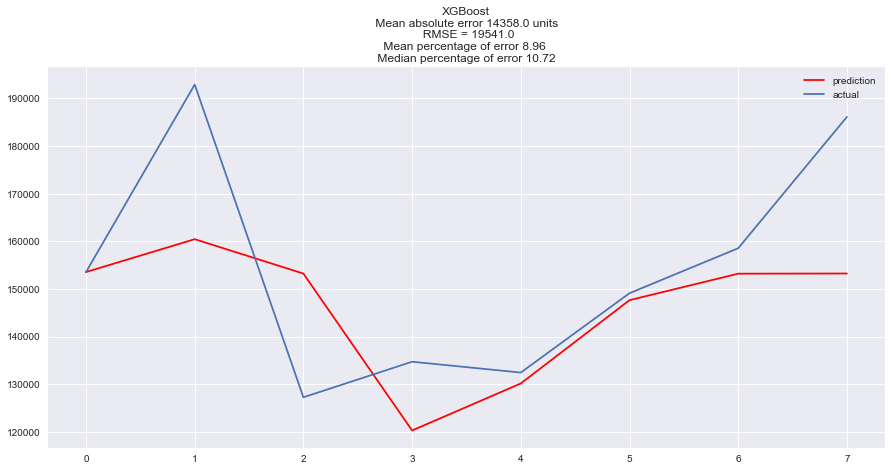

In [277]:
est = XGBRegressor(n_estimators=1000, max_depth = 5, n_jobs=-1, random_state=42, subsample = 1, learning_rate = 0.2)
est.fit(X[list(features[:55].index)], y)
# пересчитаем важность новых фич
features_new = pd.DataFrame(est.feature_importances_, index=X[list(features[:55].index)].columns, columns=['Importance']).sort_values(['Importance'], ascending=False)
prediction = est.predict(X_valid[list(features[:55].index)])
   
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_valid.values, label="actual")
error_percentage = (abs(prediction - y_valid.values) / y_valid.values)
plt.legend(loc="best")
plt.title("XGBoost\n Mean absolute error {} units \n  RMSE = {} \n Mean percentage of error {}  \n Median percentage of error {} ".format(
    round(mean_absolute_error(y_valid, prediction)),
    round(np.sqrt(mean_squared_error(y_valid, prediction))), 
    round(sum(error_percentage) / len(error_percentage) * 100, 2),
    round(sorted(error_percentage)[int(len(error_percentage) / 2)] * 100, 2) ))
plt.grid(True);
plt.show()

In [279]:
media_features = features_new[features_new.index.isin(['RegDiff', 'Press.Concurents', 'Press.Concurents_lag1', 'Press.Concurents_lag2', 'Press.Concurents_lag3',
 'Press.Concurents_lag4', 'Press.Concurents_lag5', 'Press.Concurents_lag6', 'Press.brand_X', 'Press.brand_X_lag1',
 'Press.brand_X_lag2', 'Press.brand_X_lag3', 'Press.brand_X_lag4', 'Press.brand_X_lag5', 'Press.brand_X_lag6',
 'Reg.TV.Concurents', 'Reg.TV.Concurents_lag1', 'Reg.TV.Concurents_lag2', 'Reg.TV.Concurents_lag3', 'Reg.TV.Concurents_lag4',
 'Reg.TV.Concurents_lag5', 'Reg.TV.Concurents_lag6', 'Reg.TV.brand_X', 'Reg.TV.brand_X_lag1', 'Reg.TV.brand_X_lag2', 'Reg.TV.brand_X_lag3',
 'Reg.TV.brand_X_lag4', 'Reg.TV.brand_X_lag5', 'Reg.TV.brand_X_lag6', 'Radio.Concurents', 'Radio.Concurents_lag1', 'Radio.Concurents_lag2',
 'Radio.Concurents_lag3', 'Radio.Concurents_lag4', 'Radio.Concurents_lag5', 'Radio.Concurents_lag6', 'Radio.brand_X',
 'Radio.brand_X_lag1', 'Radio.brand_X_lag2', 'Radio.brand_X_lag3', 'Radio.brand_X_lag4', 'Radio.brand_X_lag5', 'Radio.brand_X_lag6',
 'TV.Concurents', 'TV.Concurents_lag1', 'TV.Concurents_lag2', 'TV.Concurents_lag3', 'TV.Concurents_lag4', 'TV.Concurents_lag5',
 'TV.Concurents_lag6', 'TV.brand_X', 'TV.brand_X_lag1', 'TV.brand_X_lag2', 'TV.brand_X_lag3', 'TV.brand_X_lag4', 'TV.brand_X_lag5',
 'TV.brand_X_lag6'])]
media_features

,Importance
TV.Concurents_lag3,0.100721
Press.brand_X_lag1,0.004885
TV.brand_X,0.004303
Press.Concurents,0.003722
TV.Concurents_lag2,0.003605
TV.Concurents_lag4,0.003605
TV.Concurents_lag6,0.003257
TV.Concurents_lag1,0.002908
TV.Concurents,0.002791
TV.Concurents_lag5,0.002675
